In [1]:
cd /home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src

/home/roberto/Documents/Carrera/romain_ic/wavemixing_project/src


In [2]:
import os
import sys

sys.path.insert(0, os.path.abspath("./post_processing/local_calculations"))
sys.path.insert(0, os.path.abspath("./helper_functions/cloud"))
sys.path.insert(0, os.path.abspath("./file_manager"))
sys.path.insert(0, os.path.abspath("./hamiltonian"))
sys.path.insert(0, os.path.abspath("./correlation"))
sys.path.insert(0, os.path.abspath("./single_and_double_excitations_subspace"))

In [3]:
from qutip import *
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from hamiltonian.hamiltonian_builder import *


from helper_functions.operators import *
from helper_functions.cloud import *
from file_manager.visualization_preparation_tools import *
from correlation.second_order_correlation  import *
from single_and_double_excitations_subspace.parameter_generator_for_ODE import *
from single_and_double_excitations_subspace.atomic_contributions_ODE import *
from single_and_double_excitations_subspace.atomic_contributions_optimized_ODE import SolveForBeta1DandBeta2D_optimized, SolveForBeta1D_optimized

from single_and_double_excitations_subspace.QRT_dynamics_ODE import *

from post_processing.local_calculations import *
from helper_functions.cloud import *
from helper_functions.operators import *
from helper_functions.other import * 

Implementing sandwich_E:

\begin{equation}
\langle{\psi(t)}| E^*	E | {\psi(t)} \rangle = \left|\sum_{n}  e^{-i\phi_{n}} \beta_n(t) \right|^2+  4\sum_{\tilde{m}, n, m}  e^{-i(\phi_m - \phi^*_{\tilde{m}})}\left(\beta^*_{n\tilde{m}}(t)\beta_{nm}(t) \right)
\end{equation}

In [4]:
def sandwich_E(r, Beta1D, Beta2D, n, optimized = False):
    #phase vector
    phase = np.exp(-1j*n.T @ r) #e^{-kvec x r}
    if optimized == False:
        s1 = 0
        s2 = 0
        for n in range(N):
            s1 += phase[0, n]*Beta1D[n]
            if Beta2D is not None: #not Single Excitation
                for m in range(N):
                    for j in range(N):
                        s2 += 4*phase[0,m]*phase.conj()[0,j]*(Beta2D[n][j].conj()*Beta2D[n][m] )

        s = np.abs(s1)**2 + s2
    else:
        
        #Matrix of difference of phases:
        phases_difference = np.exp(-1j*(np.reshape(np.subtract.outer(n.T @ r, n.T @ r), [N,N])))
        #First term
        s  = np.abs(np.einsum("ij,kj->",np.reshape(Beta1D, [1, N]), phase))**2 
        if Beta2D is not None: #Single Excitation
        #Second term
            s += 4*np.einsum('mj,nj,nm', phases_difference,Beta2D.conj().T, Beta2D)
        
    
    return s

Implementing get_projected_state

\begin{equation}
|\bar{\psi}(t)\rangle
= \frac{ \left(\sum_{n} e^{-i\phi_n}\beta_n(t)\right) |0\rangle + 2 \sum_{n,m}  e^{-i\phi_m}\left(\beta_{nm}(t) \right)|n\rangle }{\sqrt{ \left|\sum_{n}  e^{-i\phi_{n}} \beta_n(t) \right|^2+  4\sum_{\tilde{m}, n, m}  e^{-i(\phi_m - \phi^*_{\tilde{m}})}\left(\beta^*_{n\tilde{m}}(t)\beta_{nm}(t) \right) }}
\end{equation}

Which implies: 

\begin{equation}
\beta_{\ell}
= \frac{  2 \sum_{m}  e^{-i\phi_m}\left(\beta_{\ell m}(t) \right) }{\sqrt{ \left|\sum_{n}  e^{-i\phi_{n}} \beta_n(t) \right|^2+  4\sum_{\tilde{m}, n, m}  e^{-i(\phi_m - \phi^*_{\tilde{m}})}\left(\beta^*_{n\tilde{m}}(t)\beta_{nm}(t) \right) }}
\end{equation}



In [5]:
def get_Beta1D_projected_state(r, Beta1D_steady_state, Beta2D_steady_state, n1, optimized = False):
    """ 
    Beta1D_steady_state, Beta2D_steady_state are both matrices not time evolution matrices
    """
    phase = np.exp(-1j*n1.T @ r)
    if optimized == False:
        numerator = np.zeros([N], dtype = "complex")
        for l in range(N):
            for m in range(N):
                numerator[l] += phase[0, m]*Beta2D_steady_state[l][m]
    else:
        numerator = np.einsum('ij,jk -> i', Beta2D_steady_state, phase.T)  
    
    denominator = np.sqrt(sandwich_E(r, Beta1D_steady_state, Beta2D_steady_state, n1) )

    return numerator/denominator



Implementing g2:

\begin{equation}
g^{(2)}(\tau) = \frac{\langle\bar{\psi}(\tau)|E^*E|\bar{\psi}(\tau)\rangle}{\langle\psi(t\rightarrow\infty)|E^*E| \psi(t\rightarrow\infty)\rangle}
\end{equation}

In [6]:
def get_g2(r, Beta1D_steady_state, Beta2D_steady_state, Beta1D_tau, Beta2D_tau, n1, n2, optimized = False):
    g2 = []
    if Beta2D_tau is None:
        for tau in range(len(Beta1D_tau)):
            g2.append(sandwich_E(r, Beta1D_tau[tau], None, n2, optimized)/ 
                  sandwich_E(r, Beta1D_steady_state, Beta2D_steady_state, n2, optimized))
        return g2 
    else:
        for tau in range(len(Beta1D_tau)):
            g2.append(sandwich_E(r, Beta1D_tau[tau], Beta2D_tau[tau], n2, optimized)/ 
                      sandwich_E(r, Beta1D_steady_state, Beta2D_steady_state, n2, optimized))
        return g2

### Testing implementation

In [8]:
#Initial parameters
N_atoms = N = 5
b0 = 0.1
r = random_cloud(0, N, exc_radius = None, b0 = b0)

R1 = get_nhat_from_angle(25)
R2 = get_nhat_from_angle(205)

Omega = 2
Delta = 20

tf_steady_state = 50
t_span_steady_state, dt = np.linspace(0,tf_steady_state,100, retstep = True) 

Getting steady-state evolution

In [9]:

Beta1D_t, Beta2D_t, t_span, r = SolveForBeta1DandBeta2D_optimized(N, kd = None , b0 = None, exc_radius = None, Delta = Delta, 
                                                                  Omega = Omega, wave_mixing = True, scalar = True,
                                                                  interaction = True, r = r, t_span =t_span_steady_state)  

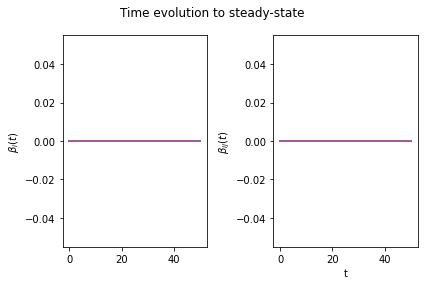

In [10]:
plt.subplots(1,2)
plt.suptitle("Time evolution to steady-state")
plt.subplot(1,2,1)
plt.ylabel(r"$\beta_{i}(t)$")
plt.plot(t_span, np.real(np.stack(Beta1D_t)[:,0:]))
plt.subplot(1,2,2)
plt.plot(t_span, np.real(np.stack(Beta2D_t))[:,0:,1])
plt.ylabel(r"$\beta_{ij}(t)$")
plt.xlabel("t")
plt.tight_layout()

In [ ]:
Beta1D_t, Beta2D_t, t_span, r = SolveForBeta1DandBeta2D_optimized(N, kd = None , b0 = None, exc_radius = None, Delta = Delta, 
                                                                  Omega = Omega, wave_mixing = True, scalar = True,
                                                                  interaction = True, r = r, t_span =t_span_steady_state)  

Getting projected state time evolution

In [ ]:
tf = 5 #shorter time
taulist, dt = np.linspace(0,tf,200, retstep = True) 
Beta1D_steady_state, Beta2D_steady_state = Beta1D_t[-1], Beta2D_t[-1]

Beta1D_projected_state = get_Beta1D_projected_state(r, Beta1D_steady_state, Beta2D_steady_state, 
                                                    R1, optimized = True)


Beta1D_tau, t_span, r = SolveForBeta1D_optimized(N, kd = None , b0 = None, exc_radius = None, Delta = Delta, 
                                                                  Omega = Omega, wave_mixing = True, scalar = True,
                                                                  interaction = True, r = r, t_span =t_span_steady_state)  


In [ ]:
plt.subplots(1,2)
plt.suptitle("Time evolution: projected state")
plt.subplot(1,2,1)
plt.ylabel(r"$\beta_{i}(\tau)$")
plt.plot(taulist, np.real(np.stack(Beta1D_tau)[:,0:]))
plt.xlabel(r"$\tau$")
plt.subplot(1,2,2)
plt.plot(taulist, np.real(np.stack(Beta2D_tau))[:,0:,1])
plt.ylabel(r"$\beta_{ij}(\tau)$")
plt.xlabel(r"$\tau$")
plt.tight_layout()

Getting g2 using monte-carlo

In [ ]:
Beta1D_steady_state = Beta1D_t[-1]
g2_MonteCarlo = get_g2(r, Beta1D_steady_state, Beta2D_steady_state, 
                       Beta1D_tau, None, R1, R2, optimized = True)

Getting g2 using exact method 

In [ ]:

S_H, S_c_ops, GTensor,M, GammaSR, DeltaSR, Omega, SR_state, r = system_spec_N(1, N_atoms, kd = None, b0 = b0, exc_radius = None , Delta = Delta, Omega = Omega, wave_mixing = True, scalar = True, r = r, beam = "plane_wave")
rho_ss_S, total_time_ss = get_steadystate(S_H, 0, r,  b0, S_c_ops, N, faseglobal = 1, rho_ss = None, rho_ss_parameter = "direct", tmax = None)


G2_ls, normalization_ls, rho_ss, total_time_ss, total_time_correlation = g2_l(S_H, 0, r, R1, R2, taulist, S_c_ops, N, faseglobal = 1, rho_ss = rho_ss_S, rho_ss_parameter = "direct", tmax = None)
g2_exact = G2_ls/normalization_ls

#sigma_ij = np.zeros([N,N], dtype="object")
#for i in range(len(sigma_ij[0])):
#    for j in range(len(sigma_ij[0])):
#        sigma_ij[i][j] = (correlation_2op_1t(S_H, rho_ss, taulist, S_c_ops, sigmam_i(N,i), sigmam_i(N,j), solver='me', reverse=True))

Comparing plots

In [ ]:
fig = plt.figure(figsize=(5, 3), dpi=300)
#plt.ylim(-0.2,14)
plt.plot(taulist, g2_MonteCarlo, label = 'Monte Carlo')
plt.plot(taulist, g2_exact, "--", label = "QuTip Exact")
#plt.title(f"N = {N}, b0 = {b0}, Omega = {Omega}, Delta = {Delta}  ")

plt.xlabel(r"$\tau$ ")
plt.ylabel(r"$ g^{(2)}(\tau)  $")
plt.legend()
plt.tight_layout()

avg_relative_error = np.average(np.abs(1- g2_MonteCarlo/g2_exact))
plt.title(f"N = {N}, $b_0$ = {b0}, $\Delta$ = {Delta}, $\Omega$ = {Omega}  \n Average relative error = {np.round(avg_relative_error, 3)}")

plt.tight_layout()
#plt.savefig(f"./benchmarking/g2_qutip_vs_MC_N{N}_b0{b0}_Omega{Omega}_avg_error_{np.round(avg_relative_error, 3)}.png", dpi = 300, tight_layout = True)

Checking if g2(0) is correctly implemented:
\begin{equation}
	g^{(2)}(\tau = 0)= \frac{1}{\left|\sum_{n}  e^{-i\phi_{n}} \beta_n(t) \right|^2+  4\sum_{\tilde{m}, n, m}  e^{-i(\phi_m - \phi^*_{\tilde{m}})}\left(\beta^*_{n\tilde{m}}(t)\beta_{nm}(t) \right)} \times \left|   \frac{ | 2 \sum_{\ell, m}  e^{-i(\phi_{\ell} + \varphi_{m})}\left(\beta_{\ell m}(t) \right) |^2 }{ \left|\sum_{n}  e^{-i\varphi_{n}} \beta_n(t) \right|^2+  4\sum_{\tilde{m}, n, m}  e^{-i(\varphi_m - \varphi^*_{\tilde{m}})}\left(\beta^*_{n\tilde{m}}(t)\beta_{nm}(t) \right)  } \right| 
    \end{equation}

Where $\varphi= k\mathbf{n_1}\mathbf{r} $ and $\phi= k\mathbf{n_2}\mathbf{r} $

In [ ]:
def get_g2_zero(r, Beta1D_steady_state, Beta2D_steady_state, n1, n2):
    """ 
    """
    N = len(r)
    phase_n1 = np.exp(-1j*n1.T @ r)
    phase_n2 = np.exp(-1j*n2.T @ r)

    numerator = 0
    for l in range(N):
        for m in range(N):
            numerator += phase_n1[0, m]*phase_n2[0, l]*Beta2D_steady_state[l][m]
    
    
    s1_n2 = 0
    s2_n2 = 0
    s1_n1 = 0
    s2_n1 = 0
    for l in range(N):
        s1_n2 += phase_n2[0, l]*Beta1D_steady_state[l]
        s1_n1 += phase_n1[0, l]*Beta1D_steady_state[l]
        for m in range(N):
            for n in range(N):
                s2_n2 += 4*phase_n2[0, m]*phase_n2[0, l].conj()  *  Beta2D_steady_state[l][n].conj()*Beta2D_steady_state[n][m]
                
                s2_n1 += 4*phase_n1[0, m]*phase_n1[0, l].conj()  *  Beta2D_steady_state[l][n].conj()*Beta2D_steady_state[n][m]

    denominator = (np.abs(s1_n2)**2 + s2_n2)*np.abs((np.abs(s1_n1)**2 + s2_n1))
    print(np.abs(numerator)**2)
    print(denominator)
    return np.abs(numerator)**2/denominator

get_g2_zero(r, Beta1D_steady_state, Beta2D_steady_state, R1, R2)

In [ ]:
g2_MonteCarlo[0]

In [ ]:
g2_exact[0]

In [ ]:
1-g2_MonteCarlo[0]/g2_exact[0]

In [ ]:
g2_of_zero_subspace_approach(r, R1, R2, Beta1D_steady_state, Beta2D_steady_state, separated = True )

In [ ]:
4*g2_of_zero_subspace_approach(r, R1, R2, Beta1D_steady_state, Beta2D_steady_state, separated = False )

### Benchmarking optimized and for-loops equations

\begin{equation} \langle{\psi(t)}| E^*	E | {\psi(t)} \rangle = \sum_{n, \tilde{n}} e^{i(\phi^*_{\tilde{n}} - \phi_{n})} \beta^*_{\tilde{n}}(t) \beta_n(t) +  \sum_{\tilde{m}, n, m}  e^{-i(\phi_m - \phi^*_{\tilde{m}})}\left(\beta^*_{n\tilde{m}}(t) + \beta^*_{\tilde{m}n}(t) \right)\left(\beta_{nm}(t) + \beta_{mn}(t) \right) \end{equation}

\begin{equation} \langle{\psi(t)}| E^*	E | {\psi(t)} \rangle = \left|\sum_{n}  e^{-i\phi_{n}} \beta_n(t) \right|^2 +  \sum_{\tilde{m}, n, m}  e^{-i(\phi_m - \phi^*_{\tilde{m}})}\left(\beta^*_{n\tilde{m}}(t) + \beta^*_{\tilde{m}n}(t) \right)\left(\beta_{nm}(t) + \beta_{mn}(t) \right) \end{equation}

\begin{equation} \langle{\psi(t)}| E^*	E | {\psi(t)} \rangle = \left|\sum_{n}  e^{-i\phi_{n}} \beta_n(t) \right|^2+  4\sum_{\tilde{m}, n, m}  e^{-i(\phi_m - \phi^*_{\tilde{m}})}\left(\beta^*_{n\tilde{m}}(t)\beta_{nm}(t) \right)\end{equation}

Other normalization: 

\begin{equation} \langle{\psi(t)}| E^*	E | {\psi(t)} \rangle = \left|\sum_{n}  e^{-i\phi_{n}} \beta_n(t) \right|^2 +  \sum_{n,m,j} \beta_{nm}(t) \bigg(   e^{-i(\phi_{n}-\phi^*_{j})} \left(    \beta^*_{jm}(t) + \beta^*_{mj}(t) \right) + e^{-i(\phi_{m}-\phi^*_{j})} \left( \beta^*_{jn}(t) + \beta^*_{nj}(t)\right) \bigg) \end{equation}

Testing values:

In [ ]:
N_atoms = N = 6
b0 = 0.1
r = random_cloud(0, N, exc_radius = None, b0 = b0)
R1 = get_nhat_from_angle(25)

tf = 3
Omega = 0.1
Delta = 20
t_span, dt = np.linspace(0,tf,100, retstep = True) 


Phases: $e^{-i(\phi_m - \phi^*_{\tilde{m}})}$ matrix  and $e^{-i(\phi_m)}$ vector column

In [ ]:
#phases
n = R1
phase = np.exp(-1j*n.T @ r)
phases_difference = np.exp(-1j*(np.reshape(np.subtract.outer(n.T @ r, n.T @ r), [N,N])))


print( "Implemented ", phases_difference[0][1])
print( "Exact ", phase[0,0]*phase.conj()[0,1])

 Sandwich E, first term: $\sum_{n, \tilde{n}} e^{i(\phi^*_{\tilde{n}} - \phi_{n})} \beta^*_{\tilde{n}}(t) \beta_n(t)$ and $\left|\sum_{n}  e^{-i\phi_{n}} \beta_n(t) \right|^2 $

In [ ]:
# Sandwich E: first term
Delta1D, Omega1D, Gamma2D, Delta2D  = GetAllODEParametersGiven_r(Omega, Delta, r, beam = "plane-wave", scalar = True)
Beta1D_t, Beta2D_t, t_span, r = SolveForBeta1DandBeta2D_optimized(N, kd = None , b0 = None, exc_radius = None, Delta = Delta , Omega = Omega, wave_mixing = True, scalar = True, interaction = True, r = r, t_span =t_span)  
Beta1D, Beta2D = Beta1D_t[-1], Beta2D_t[-1]

s1 = 0
s2 = 0
for n in range(N):
    s2 += phase[0, n]*Beta1D[n]
    for m in range(N):
        s1 += phase[0,n]*phase.conj()[0,m]*Beta1D.conj()[m]*Beta1D[n]
        #s1 += phases_difference[m][n]*Beta1D.conj()[n]*Beta1D[m]

            
print( "Exact two loop", s1)   
print( "Exact one loop", np.abs(s2)**2)            

print( "Optimized", np.abs(np.einsum("ij,kj->i",np.reshape(Beta1D, [1, N]), phase))**2)

Sandwich E, second term
$4\sum_{\tilde{m}, n, m}  e^{-i(\phi_m - \phi^*_{\tilde{m}})}\left(\beta^*_{n\tilde{m}}(t)\beta_{nm}(t) \right)$ and $ \sum_{\tilde{m}, n, m}  e^{-i(\phi_m - \phi^*_{\tilde{m}})}\left(\beta^*_{n\tilde{m}}(t) + \beta^*_{\tilde{m}n}(t) \right)\left(\beta_{nm}(t) + \beta_{mn}(t) \right)  $

In [ ]:
# Sandwich E: second term

s3 = 0
s4 = 0

s_other_normalization = 0
for n in range(N):
    for m in range(N):
        for j in range(N):
            s_other_normalization += Beta2D[n][m]*( 2*phases_difference[n][j]*Beta2D[m][j].conj() + 2*phases_difference[m][j]*Beta2D[n][j].conj())
            
            
            s3 += phases_difference[m][j]*(Beta2D[n][j].conj() + Beta2D[j][n].conj())*(Beta2D[n][m] + Beta2D[m][n])
            s4 += 4*phases_difference[m][j]*(Beta2D[n][j].conj()*Beta2D[n][m] )
            
print("Exact ", s3)
print("Exact ", s4)

print( "Optimized", 4*np.einsum('mj,nj,nm', phases_difference,Beta2D.conj().T, Beta2D)) 
print( "Other normalization", s_other_normalization)

Benchmarking projected state $2 \sum_{n,m}  e^{-i\phi_m}\left(\beta_{nm}(t) \right)|{n}\rangle$


In [ ]:
beta_ij_tau_list = np.zeros([N], dtype = "complex")
for n in range(N):
    for m in range(N):
        beta_ij_tau_list[n] += phase[0, m]*Beta2D[n][m]
        
        
print("Exact", beta_ij_tau_list)        
print("Optimized", np.einsum('ij,jk->i', Beta2D, phase.T))